# Insurance Cost Prediction

In this notebook we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to **predict the price of yearly medical bills**. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person.

The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).

The figure below presents the workflow of the training process.

![insurance cost prediction](images/insurance_cost_prediction.svg)

## Import libraries

In [1]:
import pandas as pd
import torch
from torchvision.datasets.utils import download_url
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

## 1. Prepare data

### 1.1 Download data

In [2]:
DATASET_URL = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


In [3]:
df_raw = pd.read_csv(DATA_FILENAME)
df_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### 1.2 Customize data

In [4]:
def customize_data(df_raw, rand_str):
    df = df_raw.copy(deep=True)
    # drops some rows
    df = df.sample(int(0.95*len(df)), random_state=int(ord(rand_str[0])))
    # scale input
    df.bmi = df.bmi * ord(rand_str[1])/100.
    # scale target
    df.charges = df.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        df = df.drop(['region'], axis=1)
    return df

In [5]:
rand_str = "anh-tuan"
df = customize_data(df_raw, rand_str)
df.head()

,age,sex,bmi,children,smoker,charges
27,55,female,36.0525,2,no,12759.377540
997,63,female,40.5350,0,no,14443.487240
162,54,male,43.5600,1,no,10868.574080
824,60,male,26.7520,0,no,13024.548992
392,48,male,34.5895,1,no,9322.622972


### 1.3 Convert categorical data to numbers

In [6]:
def df_to_arrays(df, input_cols, cat_cols, output_cols):
    # make a copy of the original dataframe
    df1 = df.copy(deep=True)
    # convert non-numeric categorical columns to numbers
    for col in cat_cols:
        df1[col] = df1[col].astype('category').cat.codes
    # extract input & output arrays as numpy arrays
    inputs_array = df1[input_cols].to_numpy()
    targets_array = df1[output_cols].to_numpy()
    return inputs_array, targets_array

In [7]:
input_cols = ['age', 'sex', 'bmi', 'children', 'smoker']
cat_cols = ['sex', 'smoker']
output_cols = ['charges']

inputs, targets = df_to_arrays(df, input_cols, cat_cols, output_cols)
display(inputs[:5,:])
display(targets[:5, :])

array([[55.    ,  0.    , 36.0525,  2.    ,  0.    ],
       [63.    ,  0.    , 40.535 ,  0.    ,  0.    ],
       [54.    ,  1.    , 43.56  ,  1.    ,  0.    ],
       [60.    ,  1.    , 26.752 ,  0.    ,  0.    ],
       [48.    ,  1.    , 34.5895,  1.    ,  0.    ]])

array([[12759.37754 ],
       [14443.48724 ],
       [10868.57408 ],
       [13024.548992],
       [ 9322.622972]])

### 1.4 Convert numpy arrays to tensors

In [8]:
X = torch.from_numpy(inputs.astype('float32'))
Y = torch.from_numpy(targets.astype('float32'))
X.dtype, Y.dtype

(torch.float32, torch.float32)

### 1.5 Define datasets & data loaders

In [9]:
# create dataset
dataset = TensorDataset(X, Y)
# split the dataset to training dataset & validation dataset
val_percent = 0.15
ds_size = len(dataset)
val_size = int(ds_size*val_percent)
train_size = ds_size - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
print("ds_size = {}, train_size = {}, val_size = {}".format(ds_size, train_size, val_size))

ds_size = 1271, train_size = 1081, val_size = 190


In [10]:
# create data loaders
batch_size = 95
train_loader = DataLoader(train_ds, batch_size*2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [11]:
for batch in train_loader:
    Xb, Yb = batch
    break
display(Xb[:5,:])
display(Yb[:5,:])

tensor([[34.0000,  1.0000, 23.5125,  0.0000,  0.0000],
        [24.0000,  0.0000, 43.4390,  0.0000,  0.0000],
        [39.0000,  1.0000, 32.9175,  1.0000,  1.0000],
        [50.0000,  1.0000, 35.5300,  1.0000,  1.0000],
        [39.0000,  1.0000, 29.0510,  0.0000,  1.0000]])

tensor([[ 4680.3530],
        [ 2580.2183],
        [23360.5254],
        [43595.8594],
        [20955.2949]])

### 1.6 Explorer Data

In [12]:
X_df = pd.DataFrame(X.numpy())
display(X_df.describe())

,0,1,2,3,4
count,1271.000000,1271.000000,1271.000000,1271.000000,1271.000000
mean,39.357201,0.505114,33.803879,1.098348,0.205350
std,14.045815,0.500171,6.733942,1.202591,0.404116
min,18.000000,0.000000,17.556000,0.000000,0.000000
25%,27.000000,0.000000,28.946501,0.000000,0.000000
50%,40.000000,1.000000,33.544498,1.000000,0.000000
75%,51.000000,1.000000,38.279999,2.000000,0.000000
max,64.000000,1.000000,58.443001,5.000000,1.000000


In [13]:
Y_df = pd.DataFrame(Y.numpy())
display(Y_df.describe())

,0
count,1271.000000
mean,13846.762695
std,12656.316406
min,1166.748901
25%,4942.447510
50%,9767.000000
75%,17111.432617
max,66321.242188


## 2. Create model

Since features are in different ranges, we perform feature normalization before launching gradient descent so that it converges quickly.

Since target values are so large, we do scale down targets before launching gradient descent and scale up the prediction to reduce the cost.

In [14]:
def normalize_features(X):
    mu = torch.mean(X, dim=0)
    std = torch.std(X, dim=0)
    X_norm = (X - mu)/std
    return X_norm

In [15]:
SCALE_RATIO = 1e4

def scale_down(Y):
    Ys = Y/SCALE_RATIO
    return Ys

def scale_up(Y):
    Ys = Y*SCALE_RATIO
    return Ys

In [16]:
class InsuranceModel(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.linear = nn.Linear(in_features, out_classes)
    
    def forward(self, X):
        X_norm = normalize_features(X)
        Y_hat = self.linear(X_norm)
        return Y_hat
    
    def cost_func(self, batch):
        X, Y = batch
        Y_hat = self(X)
        cost = F.mse_loss(Y_hat, scale_down(Y))
        return cost
    
    def predict(self, X):
        Y_hat = self(X)
        return scale_up(Y_hat.detach())
    
    def evaluate_batch(self, batch):
        X, Y = batch
        Y_hat = self(X)
        cost = F.mse_loss(Y_hat.detach(), scale_down(Y))
        log = {'cost': cost}
        return log

In [17]:
m, in_features = X.shape
_, out_classes = Y.shape
print("in_features = {}, out_classes = {}".format(in_features, out_classes))
print("nubmer of samples = {}".format(m))

model = InsuranceModel(in_features, out_classes)

in_features = 5, out_classes = 1
nubmer of samples = 1271


## 3. Define optimizer

In [18]:
# define optimizer
lr = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## 4. Train model

In [19]:
def evaluate_epoch(batch_evals):
    batch_costs = [log['cost'] for log in batch_evals]
    epoch_cost = sum(batch_costs)/len(batch_costs)
    log = {'cost': epoch_cost}
    return log

In [20]:
def fit(epochs, model, optimizer, train_loader, val_loader):
    logs = list()
    for i in range(epochs):
        # training phase
        for batch in train_loader:
            cost = model.cost_func(batch)
            cost.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # validation phase
        batch_logs = [model.evaluate_batch(batch) for batch in val_loader]
        epoch_log = evaluate_epoch(batch_logs)
        logs.append(epoch_log)
        
        # print log
        if ((i+1)%20 == 0) or (i == epochs-1):
            print("epoch {}: cost = {}".format(i+1, epoch_log['cost']))
    return logs

In [21]:
epochs = 100
logs = fit(epochs, model, optimizer, train_loader, val_loader)

/home/tuanva/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


epoch 20: cost = 0.4554198980331421
epoch 40: cost = 0.4322964549064636
epoch 60: cost = 0.4316578507423401
epoch 80: cost = 0.43136149644851685
epoch 100: cost = 0.43137943744659424


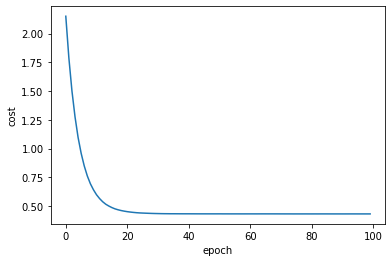

In [22]:
costs = [log['cost'].item() for log in logs]
plt.plot(costs)
plt.xlabel("epoch")
plt.ylabel("cost")
plt.show()

## 5. Make predictions

In [23]:
x, y = val_ds[0]
yh = model.predict(x)
cost = model.evaluate_batch((x, y))['cost']
print("x = {}, y = {}".format(x.tolist(), round(y.item(),2)))
print("- yh = {}\n- cost = {}".format(round(yh.item(),2), round(cost.item(),2)))

x = [24.0, 1.0, 36.99300003051758, 4.0, 0.0], y = 17813.56
- yh = 10931.89
- cost = 0.47


In [24]:
x, y = val_ds[10]
yh = model.predict(x)
cost = model.evaluate_batch((x, y))['cost']
print("x = {}, y = {}".format(x.tolist(), round(y.item(),2)))
print("- yh = {}\n- cost = {}".format(round(yh.item(),2), round(cost.item(),2)))

x = [38.0, 0.0, 29.991500854492188, 1.0, 0.0], y = 6817.27
- yh = 12659.37
- cost = 0.34


In [25]:
x, y = val_ds[23]
yh = model.predict(x)
cost = model.evaluate_batch((x, y))['cost']
print("x = {}, y = {}".format(x.tolist(), round(y.item(),2)))
print("- yh = {}\n- cost = {}".format(round(yh.item(),2), round(cost.item(),2)))

x = [48.0, 1.0, 33.858001708984375, 3.0, 0.0], y = 10546.78
- yh = 12453.92
- cost = 0.04
